# architectural analysis
This section is about reproducing figures and plots that reflect architectural behavior of the system in different scenarios.

In [126]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os

In [127]:
df = pd.read_csv("arch_param.csv")
df.head()

,suite,benchmark,chiplet,bandwidth,IPC,plp,L2 stall,local NoC stall,remote,local,...,L2 miss,L2 pending hit,L2 reservation fail,L2 data port util,mflatency,icnt2mem,icnt2sh,p latency,n latency,flit rate
0,SDK,conjugate gradient,4,160GB/s,523.8353,4.0278,0.0,0.0,340518.0,1439749.0,...,0.8670,6884.0,8011507.0,0.002,9762.0,7695.0,735.0,NaN,NaN,0.277706
1,SDK,conjugate gradient,4,300GB/s,904.7786,6.9569,0.0,0.0,340519.0,1439771.0,...,0.8649,7654.0,8910922.0,0.004,6447.0,3753.0,596.0,NaN,NaN,0.253711
2,SDK,conjugate gradient,4,600GB/s,1411.5385,10.8556,0.0,0.0,340501.0,1440145.0,...,0.8660,8859.0,9021579.0,0.007,4258.0,1607.0,196.0,NaN,NaN,0.194596
3,SDK,conjugate gradient,4,900GB/s,1775.1777,13.6570,0.0,0.0,340369.0,1440894.0,...,0.8692,10074.0,9362932.0,0.008,3783.0,1035.0,79.0,NaN,NaN,0.161817
4,SDK,conjugate gradient,4,1200GB/s,1974.4904,15.1833,0.0,0.0,340369.0,1440067.0,...,0.8688,10631.0,9588929.0,0.009,3466.0,716.0,46.0,NaN,NaN,0.134846


## Analysis of IPC and LLC effective bandwidth

In [27]:
def harmonic_mean(series):
   return len(series) / sum(1/x for x in series)

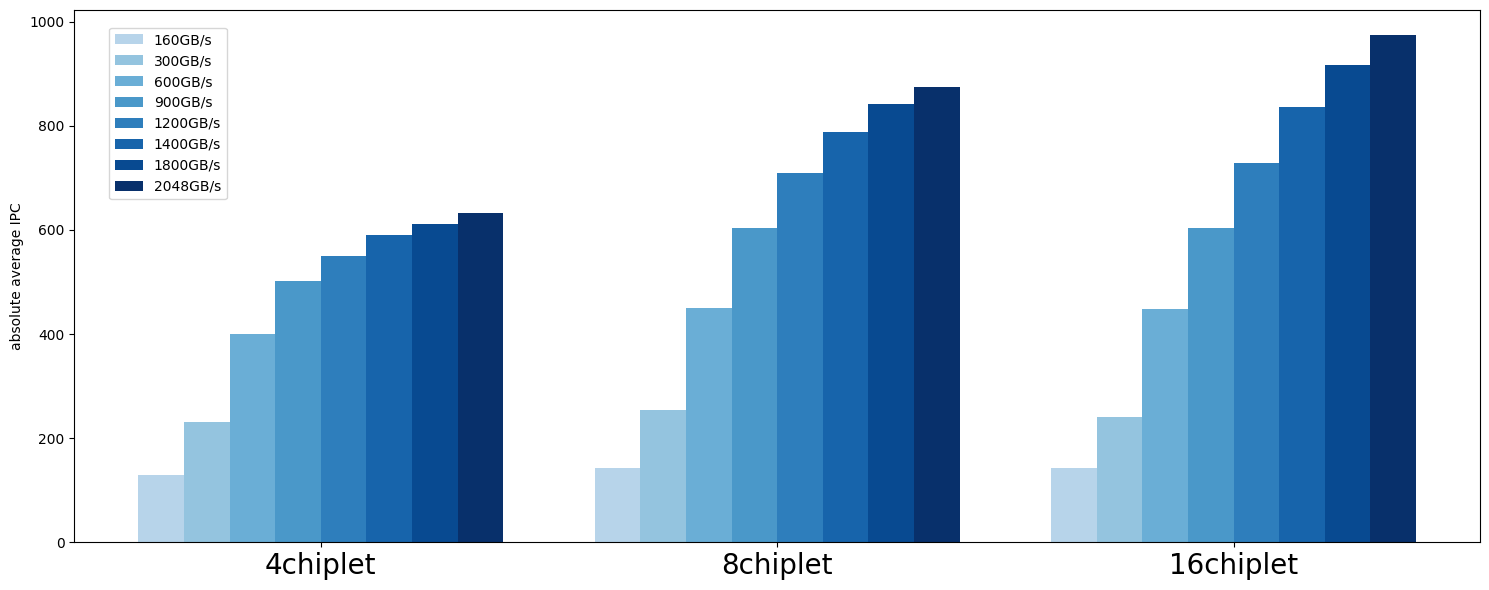

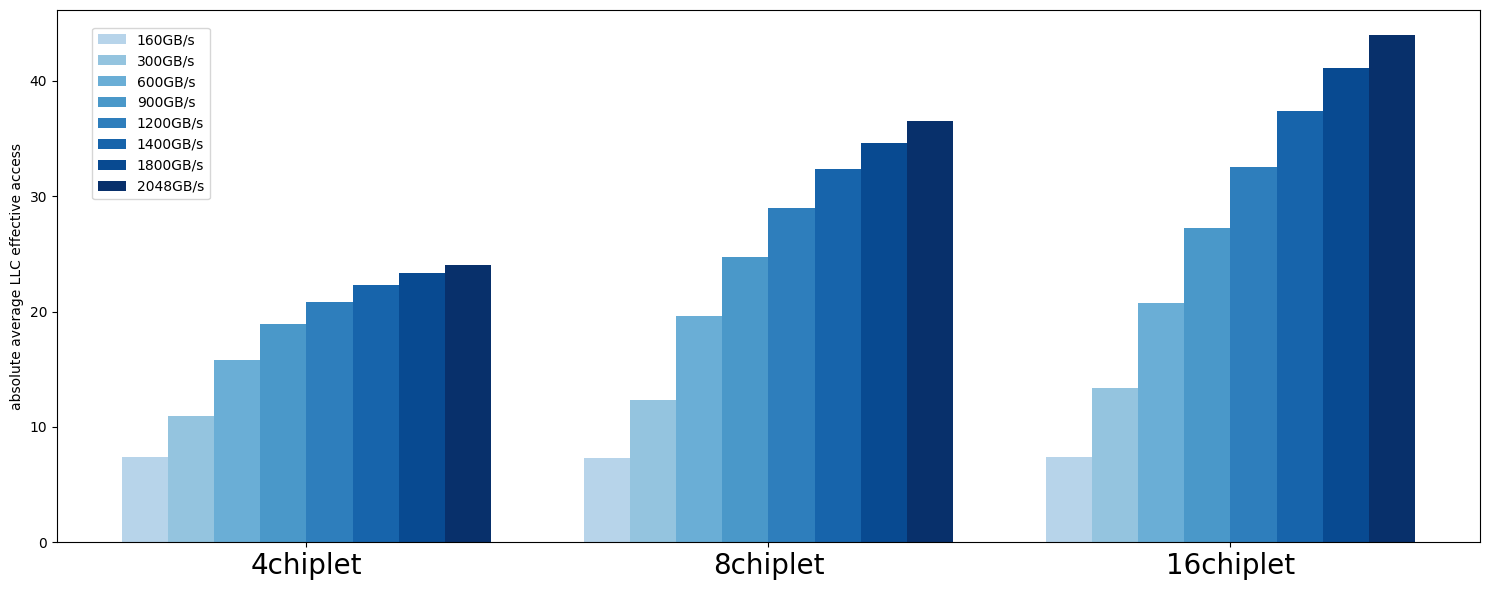

In [55]:
clean_df = df.dropna(subset=['IPC', 'plp'])
chiplets = [4, 8, 16]
bandwidths = ['160GB/s', '300GB/s', '600GB/s', '900GB/s', '1200GB/s', '1400GB/s', '1800GB/s', '2048GB/s']

ipc_means = []
plp_means = []

# Calculate means for each combination
for chiplet in chiplets:
    for bw in bandwidths:
        mask = (clean_df['chiplet'] == chiplet) & (clean_df['bandwidth'] == bw)
        ipc_mean = harmonic_mean(clean_df[mask]['IPC'])
        plp_mean = clean_df[mask]['plp'].mean()
        ipc_means.append({'chiplet': chiplet, 'bandwidth': bw, 'IPC': ipc_mean})
        plp_means.append({'chiplet': chiplet, 'bandwidth': bw, 'plp': plp_mean})

# Convert to DataFrames
avg_ipc = pd.DataFrame(ipc_means)
avg_plp = pd.DataFrame(plp_means)

def plot_metric(data, metric_name, mean_type):
   plt.figure(figsize=(15, 6))
   
   # Set up positions for grouped bars
   x = np.arange(len(chiplets))
   width = 0.8 / len(bandwidths)
   
   # Create blue color spectrum
   blues = plt.cm.Blues(np.linspace(0.3, 1, len(bandwidths)))
   
   # Plot bars for each bandwidth
   for i, (bw, color) in enumerate(zip(bandwidths, blues)):
       values = data[data['bandwidth'] == bw][metric_name]
       position = x + (i - len(bandwidths)/2 + 0.5) * width
       plt.bar(position, values, width, label=bw, color=color)

   if metric_name == 'IPC':
       metric = 'IPC'
   elif metric_name == 'plp':
       metric = 'LLC effective access'
   ylabel = "absolute average " + metric
   plt.ylabel(ylabel)
   
   # Change x-ticks to include "chiplet"
   plt.xticks(x, [f'{c}chiplet' for c in chiplets], fontsize=20)
   
   # Move legend inside the plot
   plt.legend(loc='upper left', bbox_to_anchor=(0.02, 0.98))
   
   plt.tight_layout()
   plt.savefig("results/average_absolute_" + metric_name + "_barchart.png")

# Create both plots
plot_metric(avg_ipc, 'IPC', 'Harmonic')
plot_metric(avg_plp, 'plp', 'Arithmetic')

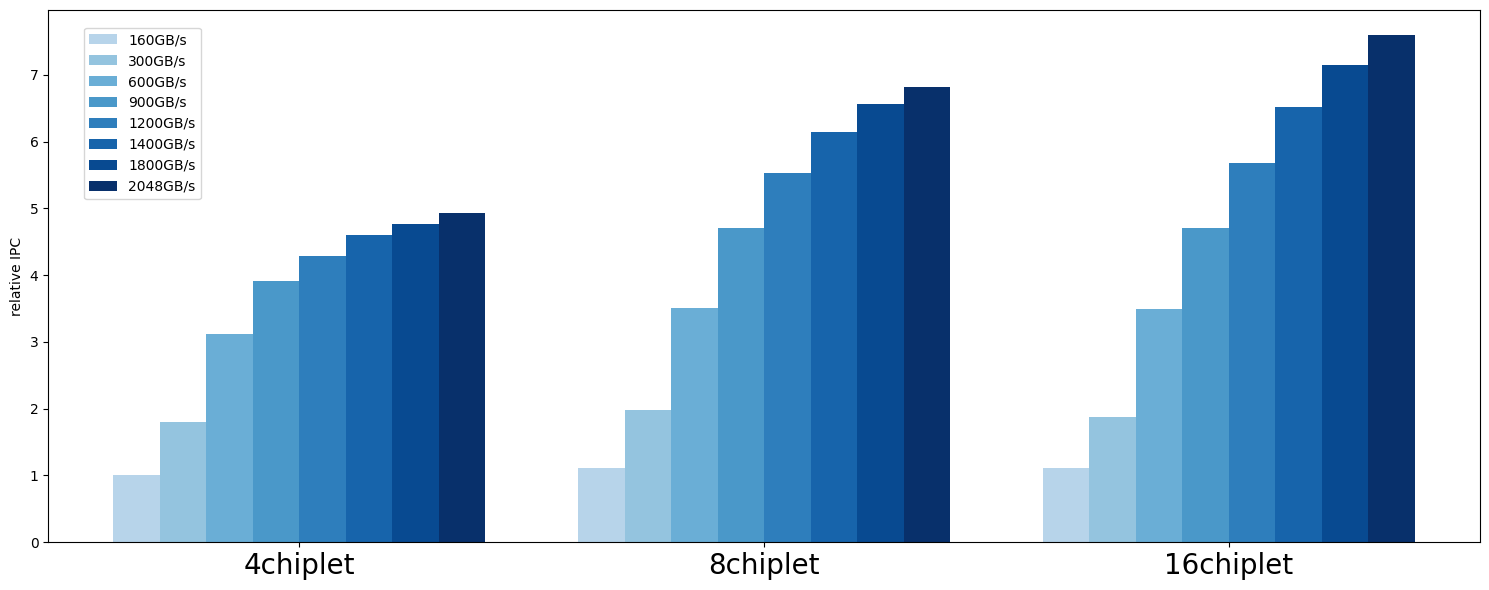

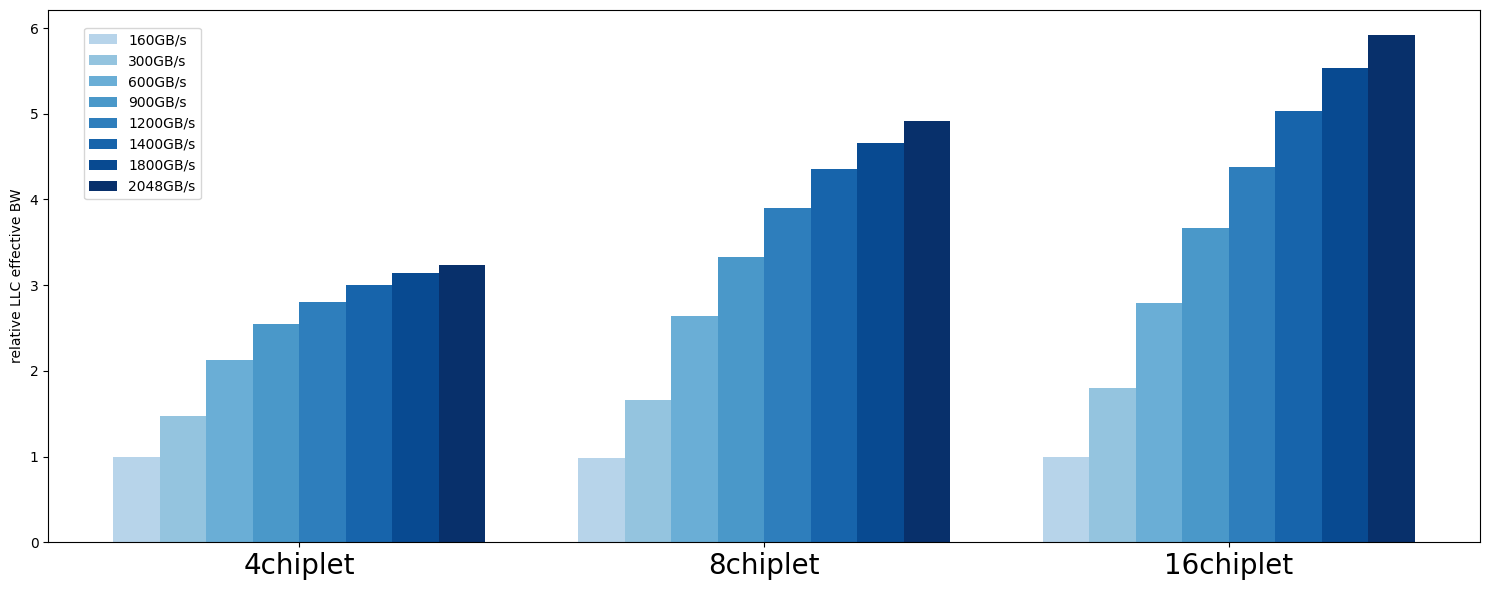

In [57]:
# Get baseline values from the previously calculated means
ipc_baseline = avg_ipc[(avg_ipc['chiplet'] == 4) & (avg_ipc['bandwidth'] == '160GB/s')]['IPC'].iloc[0]
plp_baseline = avg_plp[(avg_plp['chiplet'] == 4) & (avg_plp['bandwidth'] == '160GB/s')]['plp'].iloc[0]

# Create relative DataFrames
rel_avg_ipc = avg_ipc.copy()
rel_avg_plp = avg_plp.copy()

# Calculate relative values
rel_avg_ipc['IPC'] = rel_avg_ipc['IPC'] / ipc_baseline
rel_avg_plp['plp'] = rel_avg_plp['plp'] / plp_baseline

def plot_relative_metric(data, metric_name, mean_type):
    plt.figure(figsize=(15, 6))
    
    x = np.arange(len(chiplets))
    width = 0.8 / len(bandwidths)
    blues = plt.cm.Blues(np.linspace(0.3, 1, len(bandwidths)))
    
    for i, (bw, color) in enumerate(zip(bandwidths, blues)):
        values = data[data['bandwidth'] == bw][metric_name]
        position = x + (i - len(bandwidths)/2 + 0.5) * width
        plt.bar(position, values, width, label=bw, color=color)

    if metric_name == 'IPC':
        metric = 'IPC'
    elif metric_name == 'plp':
        metric = 'LLC effective BW'
    ylabel = "relative " + metric
    plt.ylabel(ylabel)
    plt.xticks(x, [f'{c}chiplet' for c in chiplets], fontsize=20)
    plt.legend(loc='upper left', bbox_to_anchor=(0.02, 0.98))
    #plt.axhline(y=1, color='red', linestyle='--', alpha=0.5)
    plt.tight_layout()
    plt.savefig("results/relative_" + metric_name + "_barchart.png")

# Create both relative plots
plot_relative_metric(rel_avg_ipc, 'IPC', 'Harmonic')
plot_relative_metric(rel_avg_plp, 'plp', 'Arithmetic')

## Analysis of GPU throughput

In [58]:
def harmonic_mean(series):
   return len(series) / sum(1/x for x in series)

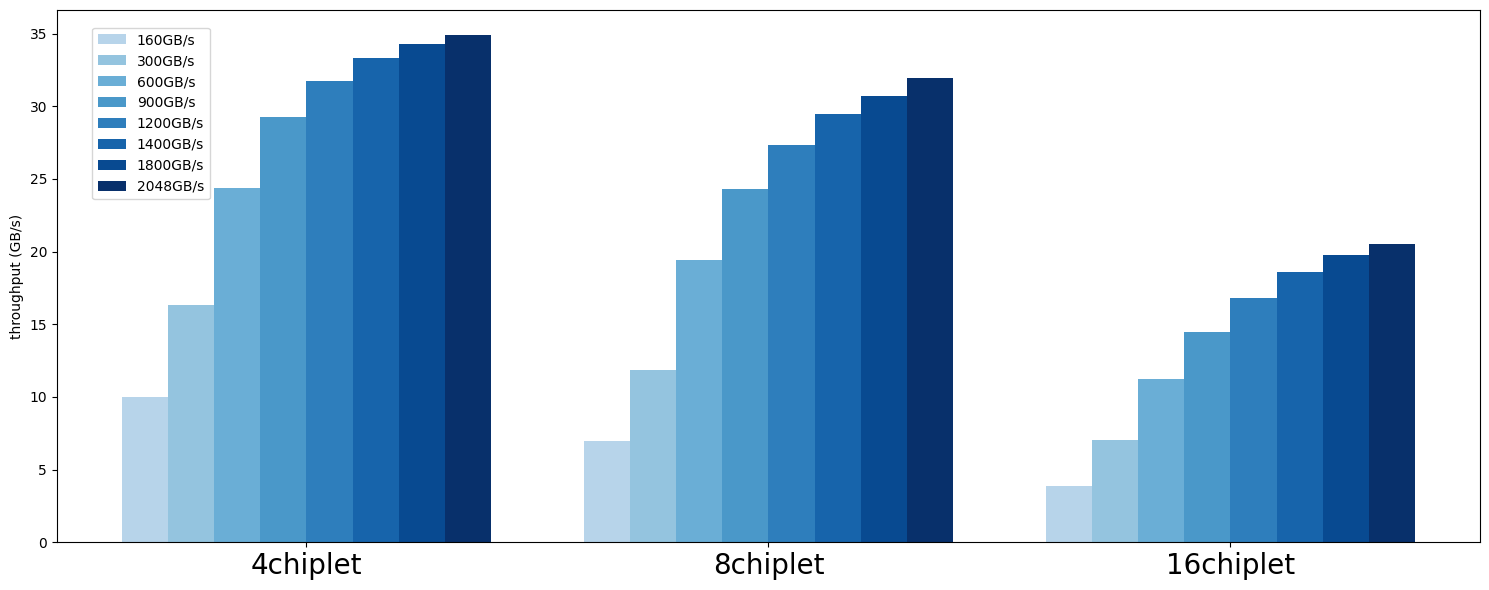

In [65]:
clean_df = df.dropna(subset=['GPU throughput'])
chiplets = [4, 8, 16]
bandwidths = ['160GB/s', '300GB/s', '600GB/s', '900GB/s', '1200GB/s', '1400GB/s', '1800GB/s', '2048GB/s']

gpu_throughput_means = []

# Calculate means for each combination
for chiplet in chiplets:
    for bw in bandwidths:
        mask = (clean_df['chiplet'] == chiplet) & (clean_df['bandwidth'] == bw)
        throughput_mean = harmonic_mean(clean_df[mask]['GPU throughput']) * 1.132 # convert bytes per cycle to GB/s
        gpu_throughput_means.append({'chiplet': chiplet, 'bandwidth': bw, 'GPU throughput': throughput_mean})

# Convert to DataFrames
avg_gpu_throughput = pd.DataFrame(gpu_throughput_means)

def plot_relative_metric(data, metric_name, mean_type):
    plt.figure(figsize=(15, 6))
    
    x = np.arange(len(chiplets))
    width = 0.8 / len(bandwidths)
    blues = plt.cm.Blues(np.linspace(0.3, 1, len(bandwidths)))
    
    for i, (bw, color) in enumerate(zip(bandwidths, blues)):
        values = data[data['bandwidth'] == bw][metric_name]
        position = x + (i - len(bandwidths)/2 + 0.5) * width
        plt.bar(position, values, width, label=bw, color=color)

    plt.ylabel("throughput (GB/s)")
    plt.xticks(x, [f'{c}chiplet' for c in chiplets], fontsize=20)
    plt.legend(loc='upper left', bbox_to_anchor=(0.02, 0.98))
    #plt.axhline(y=1, color='red', linestyle='--', alpha=0.5)
    plt.tight_layout()
    plt.savefig("results/absolute_GPU_throughput_barchart.png")

# Create both relative plots
plot_relative_metric(avg_gpu_throughput, 'GPU throughput', 'Harmonic')

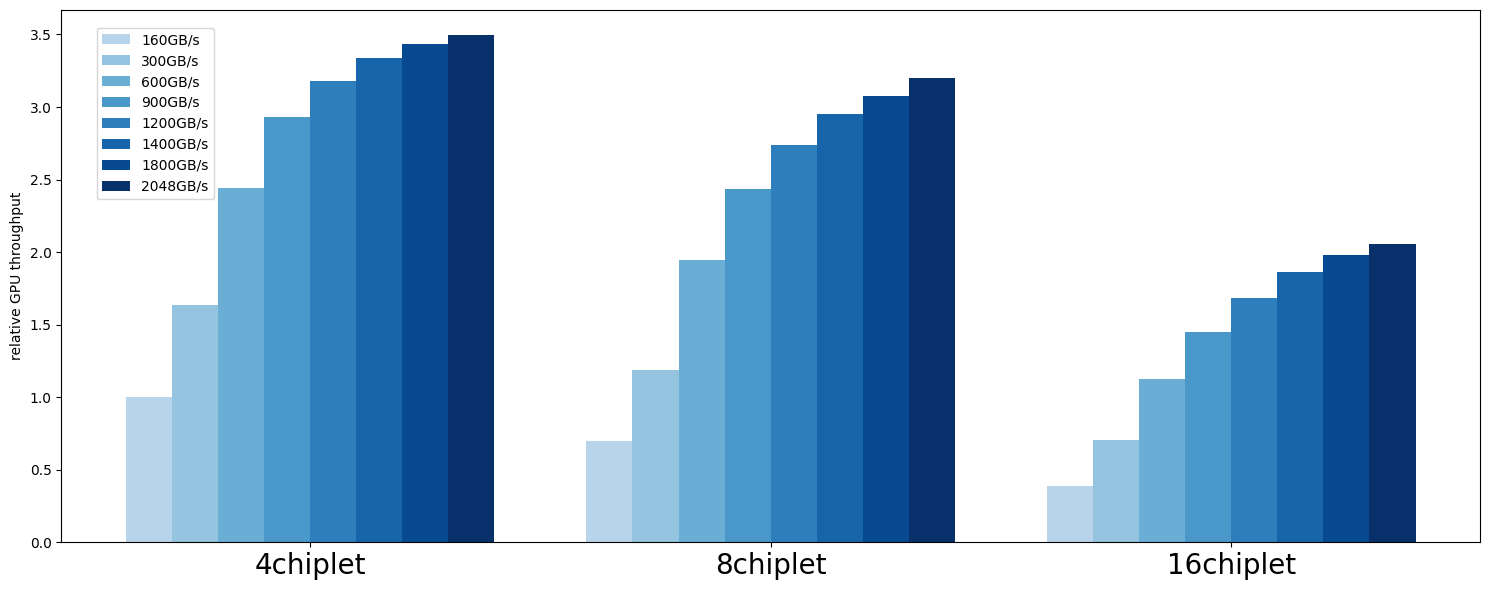

In [69]:
throughput_baseline = avg_gpu_throughput[(avg_gpu_throughput['chiplet'] == 4) & (avg_gpu_throughput['bandwidth'] == '160GB/s')]['GPU throughput'].iloc[0]

# Create relative DataFrames
rel_avg_thr = avg_gpu_throughput.copy()

# Calculate relative values
rel_avg_thr['GPU throughput'] = rel_avg_thr['GPU throughput'] / throughput_baseline

def plot_relative_metric(data, metric_name, mean_type):
    plt.figure(figsize=(15, 6))
    
    x = np.arange(len(chiplets))
    width = 0.8 / len(bandwidths)
    blues = plt.cm.Blues(np.linspace(0.3, 1, len(bandwidths)))
    
    for i, (bw, color) in enumerate(zip(bandwidths, blues)):
        values = data[data['bandwidth'] == bw][metric_name]
        position = x + (i - len(bandwidths)/2 + 0.5) * width
        plt.bar(position, values, width, label=bw, color=color)

    plt.ylabel("relative GPU throughput")
    plt.xticks(x, [f'{c}chiplet' for c in chiplets], fontsize=20)
    plt.legend(loc='upper left', bbox_to_anchor=(0.02, 0.98))
    #plt.axhline(y=1, color='red', linestyle='--', alpha=0.5)
    plt.tight_layout()
    plt.savefig("results/relative_gpu_throughput_barchart.png")
    
# Create both relative plots
plot_relative_metric(rel_avg_thr, 'GPU throughput', 'Harmonic')

## Analysis of Cache port utilization

In [2]:
def arithmetic_mean(series):
   return sum(x for x in series) / len(series)

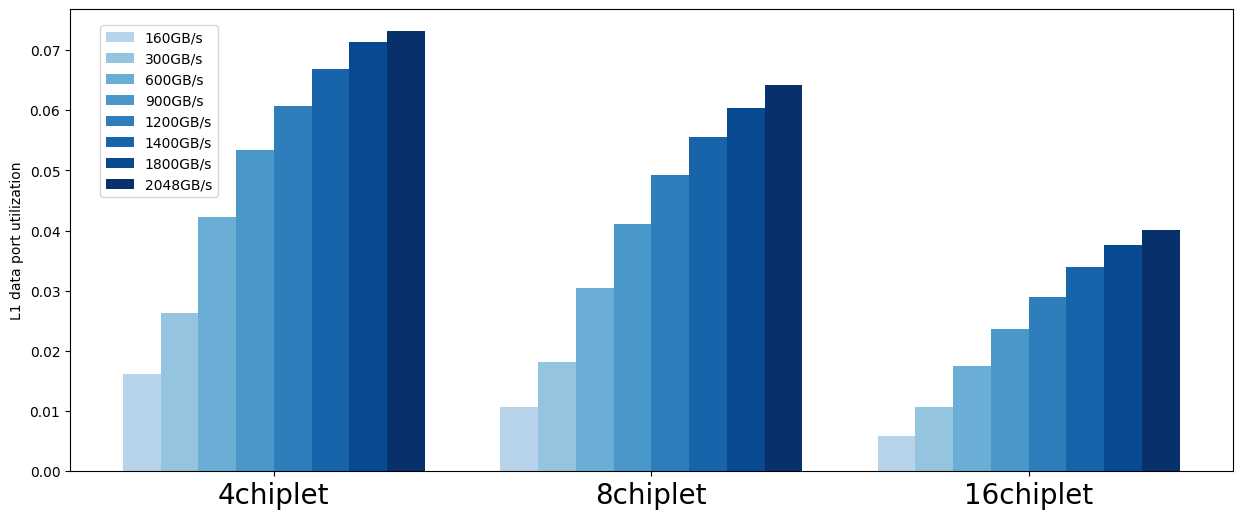

In [8]:
clean_df = df.dropna(subset=['L1 data port util'])
chiplets = [4, 8, 16]
bandwidths = ['160GB/s', '300GB/s', '600GB/s', '900GB/s', '1200GB/s', '1400GB/s', '1800GB/s', '2048GB/s']

gpu_throughput_means = []

# Calculate means for each combination
for chiplet in chiplets:
    for bw in bandwidths:
        mask = (clean_df['chiplet'] == chiplet) & (clean_df['bandwidth'] == bw)
        throughput_mean = arithmetic_mean(clean_df[mask]['L1 data port util'])
        gpu_throughput_means.append({'chiplet': chiplet, 'bandwidth': bw, 'L1 data port util': throughput_mean})

# Convert to DataFrames
avg_gpu_throughput = pd.DataFrame(gpu_throughput_means)

def plot_relative_metric(data, metric_name, mean_type):
    plt.figure(figsize=(15, 6))
    
    x = np.arange(len(chiplets))
    width = 0.8 / len(bandwidths)
    blues = plt.cm.Blues(np.linspace(0.3, 1, len(bandwidths)))
    
    for i, (bw, color) in enumerate(zip(bandwidths, blues)):
        values = data[data['bandwidth'] == bw][metric_name]
        position = x + (i - len(bandwidths)/2 + 0.5) * width
        plt.bar(position, values, width, label=bw, color=color)

    plt.ylabel("L1 data port utilization")
    plt.xticks(x, [f'{c}chiplet' for c in chiplets], fontsize=20)
    plt.legend(loc='upper left', bbox_to_anchor=(0.02, 0.98))
    #plt.axhline(y=1, color='red', linestyle='--', alpha=0.5)
    #plt.tight_layout()
    plt.savefig("results/L1_dataport_util.png")

# Create both relative plots
plot_relative_metric(avg_gpu_throughput, 'L1 data port util', 'arithmetic')

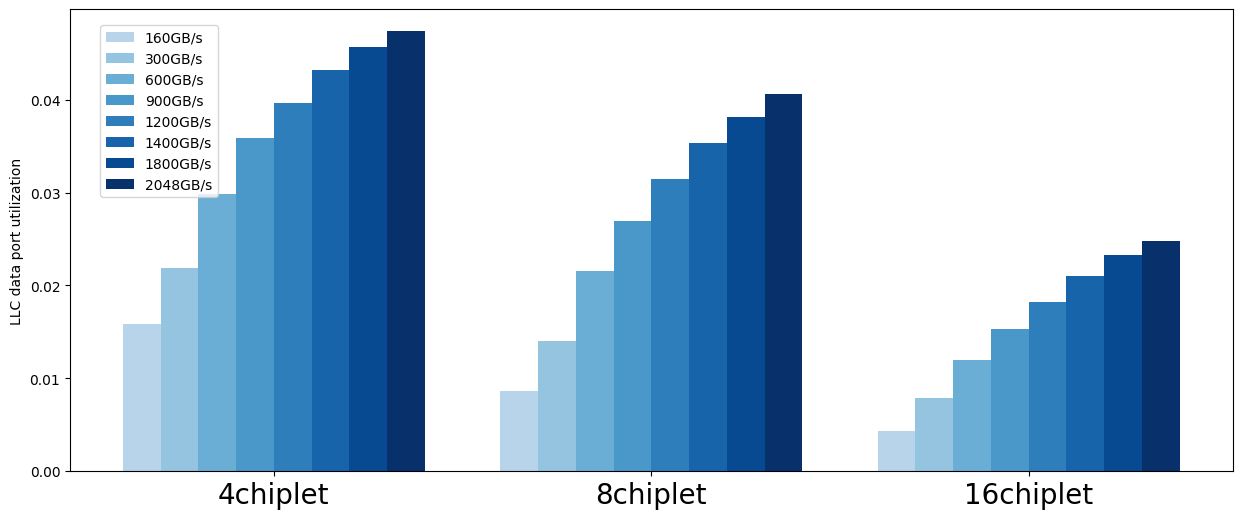

In [9]:
clean_df = df.dropna(subset=['L2 data port util'])
chiplets = [4, 8, 16]
bandwidths = ['160GB/s', '300GB/s', '600GB/s', '900GB/s', '1200GB/s', '1400GB/s', '1800GB/s', '2048GB/s']

gpu_throughput_means = []

# Calculate means for each combination
for chiplet in chiplets:
    for bw in bandwidths:
        mask = (clean_df['chiplet'] == chiplet) & (clean_df['bandwidth'] == bw)
        throughput_mean = arithmetic_mean(clean_df[mask]['L2 data port util'])
        gpu_throughput_means.append({'chiplet': chiplet, 'bandwidth': bw, 'L2 data port util': throughput_mean})

# Convert to DataFrames
avg_gpu_throughput = pd.DataFrame(gpu_throughput_means)

def plot_relative_metric(data, metric_name, mean_type):
    plt.figure(figsize=(15, 6))
    
    x = np.arange(len(chiplets))
    width = 0.8 / len(bandwidths)
    blues = plt.cm.Blues(np.linspace(0.3, 1, len(bandwidths)))
    
    for i, (bw, color) in enumerate(zip(bandwidths, blues)):
        values = data[data['bandwidth'] == bw][metric_name]
        position = x + (i - len(bandwidths)/2 + 0.5) * width
        plt.bar(position, values, width, label=bw, color=color)

    plt.ylabel("LLC data port utilization")
    plt.xticks(x, [f'{c}chiplet' for c in chiplets], fontsize=20)
    plt.legend(loc='upper left', bbox_to_anchor=(0.02, 0.98))
    #plt.axhline(y=1, color='red', linestyle='--', alpha=0.5)
    #plt.tight_layout()
    plt.savefig("results/LLC_dataport_util.png")

# Create both relative plots
plot_relative_metric(avg_gpu_throughput, 'L2 data port util', 'arithmetic')

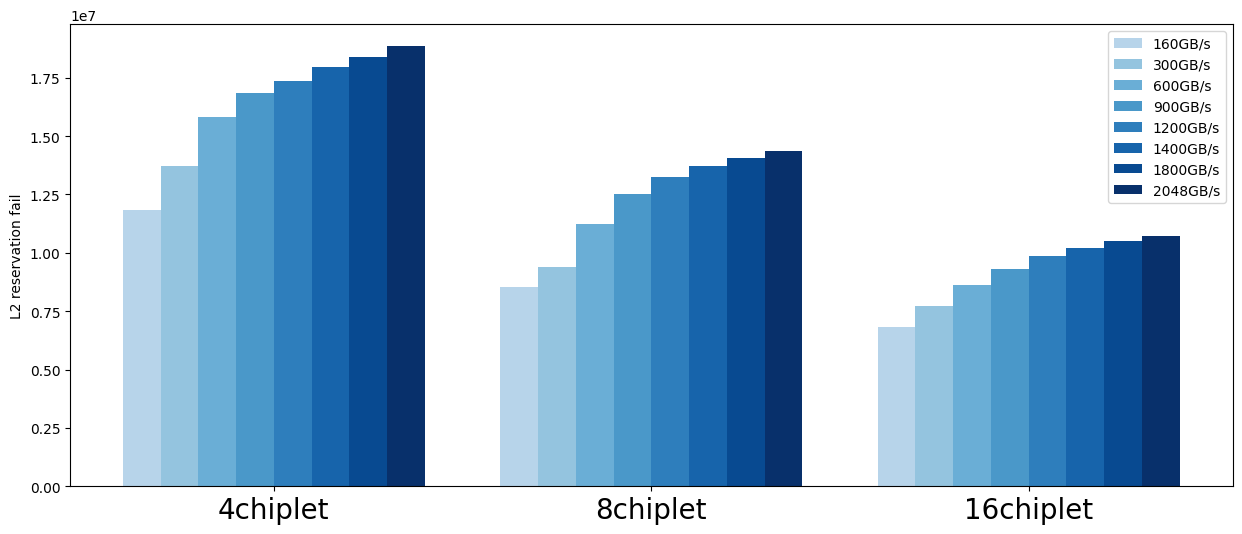

In [17]:
clean_df = df.dropna(subset=['L2 reservation fail'])
chiplets = [4, 8, 16]
bandwidths = ['160GB/s', '300GB/s', '600GB/s', '900GB/s', '1200GB/s', '1400GB/s', '1800GB/s', '2048GB/s']

gpu_throughput_means = []

# Calculate means for each combination
for chiplet in chiplets:
    for bw in bandwidths:
        mask = (clean_df['chiplet'] == chiplet) & (clean_df['bandwidth'] == bw)
        throughput_mean = arithmetic_mean(clean_df[mask]['L2 reservation fail'])
        gpu_throughput_means.append({'chiplet': chiplet, 'bandwidth': bw, 'L2 reservation fail': throughput_mean})

# Convert to DataFrames
avg_gpu_throughput = pd.DataFrame(gpu_throughput_means)

def plot_relative_metric(data, metric_name, mean_type):
    plt.figure(figsize=(15, 6))
    
    x = np.arange(len(chiplets))
    width = 0.8 / len(bandwidths)
    blues = plt.cm.Blues(np.linspace(0.3, 1, len(bandwidths)))
    
    for i, (bw, color) in enumerate(zip(bandwidths, blues)):
        values = data[data['bandwidth'] == bw][metric_name]
        position = x + (i - len(bandwidths)/2 + 0.5) * width
        plt.bar(position, values, width, label=bw, color=color)

    plt.ylabel("L2 reservation fail")
    plt.xticks(x, [f'{c}chiplet' for c in chiplets], fontsize=20)
    plt.legend()
    #plt.axhline(y=1, color='red', linestyle='--', alpha=0.5)
    #plt.tight_layout()
    plt.savefig("results/L2_reservation_fail.png")
    #plt.show()
# Create both relative plots
plot_relative_metric(avg_gpu_throughput, 'L2 reservation fail', 'arithmetic')

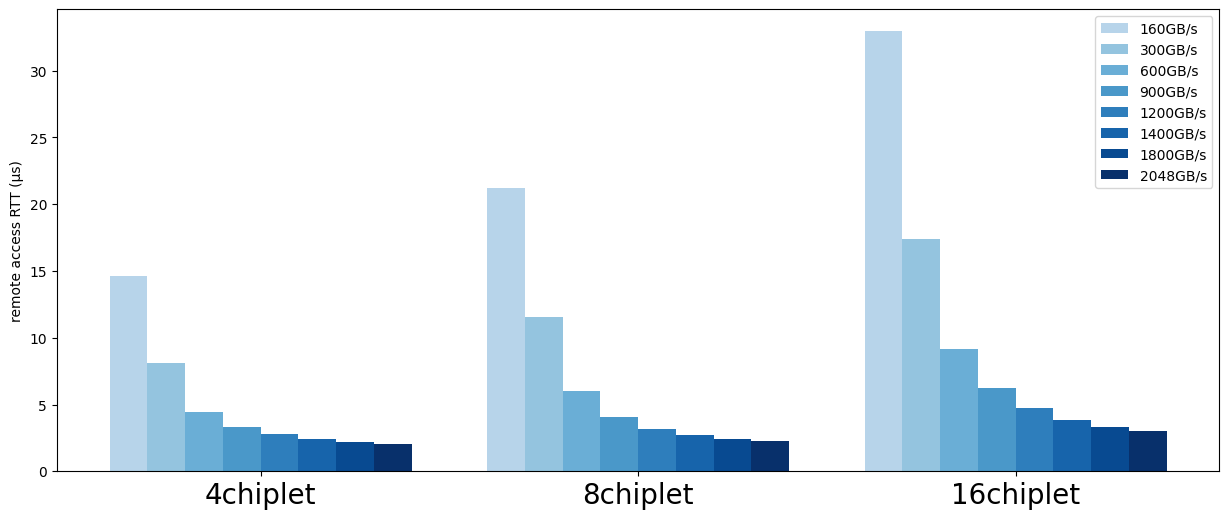

In [27]:
clean_df = df.dropna(subset=['mflatency'])
chiplets = [4, 8, 16]
bandwidths = ['160GB/s', '300GB/s', '600GB/s', '900GB/s', '1200GB/s', '1400GB/s', '1800GB/s', '2048GB/s']

gpu_throughput_means = []

# Calculate means for each combination
for chiplet in chiplets:
    for bw in bandwidths:
        mask = (clean_df['chiplet'] == chiplet) & (clean_df['bandwidth'] == bw)
        throughput_mean = arithmetic_mean(clean_df[mask]['mflatency']) * 0.88 / 1000 # convert cycle time to ns
        gpu_throughput_means.append({'chiplet': chiplet, 'bandwidth': bw, 'mflatency': throughput_mean})

# Convert to DataFrames
avg_gpu_throughput = pd.DataFrame(gpu_throughput_means)

def plot_relative_metric(data, metric_name, mean_type):
    plt.figure(figsize=(15, 6))
    
    x = np.arange(len(chiplets))
    width = 0.8 / len(bandwidths)
    blues = plt.cm.Blues(np.linspace(0.3, 1, len(bandwidths)))
    
    for i, (bw, color) in enumerate(zip(bandwidths, blues)):
        values = data[data['bandwidth'] == bw][metric_name]
        position = x + (i - len(bandwidths)/2 + 0.5) * width
        plt.bar(position, values, width, label=bw, color=color)

    plt.ylabel("remote access RTT (\u03bcs)")
    plt.xticks(x, [f'{c}chiplet' for c in chiplets], fontsize=20)
    plt.legend()
    #plt.axhline(y=1, color='red', linestyle='--', alpha=0.5)
    #plt.tight_layout()
    plt.savefig("results/mf_latency.png")
    #plt.show()
# Create both relative plots
plot_relative_metric(avg_gpu_throughput, 'mflatency', 'arithmetic')

## Analysis of per benchmark results

In [140]:
suites = df['suite'].unique()
metric_column =['IPC', 'plp', 'remote', 'local', 'GPU throughput', 'L1 miss', 'L1 pending hit', 'L1 reservation fail', 'L1 data port util', 'L2 miss', 'L2 pending hit', 'L2 reservation fail', 'L2 data port util', 'mflatency', 'icnt2mem', 'icnt2sh', 'p latency', 'n latency', 'flit rate']
clean_df = df.dropna(subset=metric_column, how='all')
for suite in suites:
    suite_df = clean_df[clean_df['suite'] == suite]
    benchmarks = suite_df['benchmark'].unique()
    for benchmark in benchmarks:
        bench_df = suite_df[suite_df['benchmark'] == benchmark]
        for param in metric_column:
            param_means = []
            for chiplet in [4, 8, 16]:
               for bw in ['160GB/s', '300GB/s', '600GB/s', '900GB/s', '1200GB/s', '1400GB/s', '1800GB/s', '2048GB/s']:
                   if param == 'flit rate':
                       if bw == '160GB/s':
                           coefficient = 40 * 1 # 40B flit size - 1 GHz NoC frequency
                       elif bw == '300GB/s':
                           coefficient = 40 * 1.875
                       elif bw == '600GB/s':
                           coefficient = 40 * 3.75
                       elif bw == '900GB/s':
                           coefficient = 40 * 5.625
                       elif bw == '1200GB/s':
                           coefficient = 40 * 7.5
                       elif bw == '1400GB/s':
                           coefficient = 40 * 9.375
                       elif bw == '1800GB/s':
                           coefficient = 40 * 11.25
                       elif bw == '2048GB/s':
                           coefficient = 40 * 12.8
                   elif param == 'GPU throughput':
                       coefficient = 1.132
                   elif param == 'mflatency' or param == 'icnt2mem' or param == 'icnt2sh':
                       coefficient = 0.88 / 1000
                   elif param == 'p latency' or param == 'n latency':
                       if bw == '160GB/s':
                           coefficient = 1 / 1
                       elif bw == '300GB/s':
                           coefficient = 1 / 1.875  # 1.875 is NoC frequency in GHz. multiply the frequency by 1000 to measure it in Microsecond.
                       elif bw == '600GB/s':
                           coefficient = 1 / 3.75
                       elif bw == '900GB/s':
                           coefficient = 1 / 5.625
                       elif bw == '1200GB/s':
                           coefficient = 1 / 7.5
                       elif bw == '1400GB/s':
                           coefficient = 1 / 9.375
                       elif bw == '1800GB/s':
                           coefficient = 1 / 11.25
                       elif bw == '2048GB/s':
                           coefficient = 1 / 12.8
                   mask = (df['chiplet'] == chiplet) & (df['bandwidth'] == bw)
                   if len(df[mask]) > 0:
                       param_mean = df[mask][param].iloc[0] * coefficient
                       param_means.append({'chiplet': chiplet, 'bandwidth': bw, param: param_mean})
            
            # Create DataFrame
            param_avg = pd.DataFrame(param_means)
        
            plt.figure(figsize=(30, 10))
            figure, ax = plt.subplots(2, 1, figsize=(15, 12))
        
            ylabel = ""
            if param == "plp":
                ylabel = "LLC effective BW"
            elif param == "remote":
                ylabel = "remote request"
            elif param == "local":
                ylabel = "local request"
            elif param == "GPU throughput":
                ylabel = "GPU throughput (GB/s)"
            elif param == "L1 miss":
                ylabel = "L1 miss rate"
            elif param == "L2 miss":
                ylabel = "L2 miss"
            elif param == "mflatency":
                ylabel = "remote access RTT (\u03bcs)"
            elif param == "icnt2mem":
                ylabel = "average remote requst latency (\u03bcs)"
            elif param == "icnt2sh":
                ylabel = "average remote reply latency"
            elif param == "p latency":
                ylabel = "packet latency (\u03bcs)"
            elif param == "n latency":
                ylabel = "network latency (\u03bcs)"
            elif param == "flit rate":
                ylabel = "Network throughput (GB/s)"
            for i, (bw, color) in enumerate(zip(['160GB/s', '300GB/s', '600GB/s', '900GB/s', '1200GB/s', '1400GB/s', '1800GB/s', '2048GB/s'], blues)):
               values = param_avg[param_avg['bandwidth'] == bw][param]
               position = x + (i - 4 + 0.5) * width
               ax[0].bar(position, values, width, label=bw, color=color)
        
            ax[0].set_ylabel('absolute ' + ylabel, fontsize=20)
            ax[0].set_xticks(x, ['4chiplet', '8chiplet', '16chiplet'], fontsize=20)
            #plt.show()
        
            # calculate relative values
            baseline = param_avg[(param_avg['chiplet'] == 4) & (avg_ipc['bandwidth'] == '160GB/s')][param].iloc[0]
            param_avg[param] = param_avg[param] / baseline
            
            x = np.arange(3)  # for 4, 8, 16 chiplets
            width = 0.8 / len(['160GB/s', '300GB/s', '600GB/s', '900GB/s', '1200GB/s', '1400GB/s', '1800GB/s', '2048GB/s'])
            blues = plt.cm.Blues(np.linspace(0.3, 1, 8))
            
            for i, (bw, color) in enumerate(zip(['160GB/s', '300GB/s', '600GB/s', '900GB/s', '1200GB/s', '1400GB/s', '1800GB/s', '2048GB/s'], blues)):
               values = param_avg[param_avg['bandwidth'] == bw][param]
               position = x + (i - 4 + 0.5) * width
               ax[1].bar(position, values, width, label=bw, color=color)
        
            if "(" in ylabel.split(" ")[-1] and ")" in ylabel.split(" ")[-1]:
                ylabel = " ".join(ylabel.split(" ")[:-1])
            ax[1].set_ylabel('Relative ' + ylabel, fontsize=20)
            ax[1].set_xticks(x, ['4chiplet', '8chiplet', '16chiplet'], fontsize=20)
            ax[1].axhline(y=1, color='red', linestyle='--', alpha=0.3)
        
            plt.legend(loc='upper left', bbox_to_anchor=(0.02, 0.98))
            plt.tight_layout()
            if not os.path.exists("results/benchmarks/" + suite + "/" + benchmark):
                os.makedirs("results/benchmarks/" + suite + "/" + benchmark)
            plt.savefig("results/benchmarks/" + suite + "/" + benchmark + "/" + ylabel + ".png")
            plt.close()

/var/folders/tz/twpl0tbs3bl5mb3vdgf3gdrc0000gn/T/ipykernel_1354/4088268779.py:60: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  figure, ax = plt.subplots(2, 1, figsize=(15, 12))
/var/folders/tz/twpl0tbs3bl5mb3vdgf3gdrc0000gn/T/ipykernel_1354/4088268779.py:59: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure(figsize=(30, 10))


<Figure size 3000x1000 with 0 Axes>

<Figure size 3000x1000 with 0 Axes>

<Figure size 3000x1000 with 0 Axes>

<Figure size 3000x1000 with 0 Axes>

<Figure size 3000x1000 with 0 Axes>

<Figure size 3000x1000 with 0 Axes>

<Figure size 3000x1000 with 0 Axes>

<Figure size 3000x1000 with 0 Axes>

<Figure size 3000x1000 with 0 Axes>

<Figure size 3000x1000 with 0 Axes>

<Figure size 3000x1000 with 0 Axes>

<Figure size 3000x1000 with 0 Axes>

<Figure size 3000x1000 with 0 Axes>

<Figure size 3000x1000 with 0 Axes>

<Figure size 3000x1000 with 0 Axes>

<Figure size 3000x1000 with 0 Axes>

<Figure size 3000x1000 with 0 Axes>

<Figure size 3000x1000 with 0 Axes>

<Figure size 3000x1000 with 0 Axes>

<Figure size 3000x1000 with 0 Axes>

<Figure size 3000x1000 with 0 Axes>

<Figure size 3000x1000 with 0 Axes>

<Figure size 3000x1000 with 0 Axes>

<Figure size 3000x1000 with 0 Axes>

<Figure size 3000x1000 with 0 Axes>

<Figure size 3000x1000 with 0 Axes>

<Figure size 3000x1000 with 0 Axes>

<Figure size 3000x1000 with 0 Axes>

<Figure size 3000x1000 with 0 Axes>

<Figure size 3000x1000 with 0 Axes>

<Figure size 3000x1000 with 0 Axes>

<Figure size 3000x1000 with 0 Axes>

<Figure size 3000x1000 with 0 Axes>

<Figure size 3000x1000 with 0 Axes>

<Figure size 3000x1000 with 0 Axes>

<Figure size 3000x1000 with 0 Axes>

<Figure size 3000x1000 with 0 Axes>

<Figure size 3000x1000 with 0 Axes>

<Figure size 3000x1000 with 0 Axes>

<Figure size 3000x1000 with 0 Axes>

<Figure size 3000x1000 with 0 Axes>

<Figure size 3000x1000 with 0 Axes>

<Figure size 3000x1000 with 0 Axes>

<Figure size 3000x1000 with 0 Axes>

<Figure size 3000x1000 with 0 Axes>

<Figure size 3000x1000 with 0 Axes>

<Figure size 3000x1000 with 0 Axes>

<Figure size 3000x1000 with 0 Axes>

<Figure size 3000x1000 with 0 Axes>

<Figure size 3000x1000 with 0 Axes>

<Figure size 3000x1000 with 0 Axes>

<Figure size 3000x1000 with 0 Axes>

<Figure size 3000x1000 with 0 Axes>

<Figure size 3000x1000 with 0 Axes>

<Figure size 3000x1000 with 0 Axes>

<Figure size 3000x1000 with 0 Axes>

<Figure size 3000x1000 with 0 Axes>

<Figure size 3000x1000 with 0 Axes>

<Figure size 3000x1000 with 0 Axes>

<Figure size 3000x1000 with 0 Axes>

<Figure size 3000x1000 with 0 Axes>

<Figure size 3000x1000 with 0 Axes>

<Figure size 3000x1000 with 0 Axes>

<Figure size 3000x1000 with 0 Axes>

<Figure size 3000x1000 with 0 Axes>

<Figure size 3000x1000 with 0 Axes>

<Figure size 3000x1000 with 0 Axes>

<Figure size 3000x1000 with 0 Axes>

<Figure size 3000x1000 with 0 Axes>

<Figure size 3000x1000 with 0 Axes>

<Figure size 3000x1000 with 0 Axes>

<Figure size 3000x1000 with 0 Axes>

<Figure size 3000x1000 with 0 Axes>

<Figure size 3000x1000 with 0 Axes>

<Figure size 3000x1000 with 0 Axes>

<Figure size 3000x1000 with 0 Axes>

<Figure size 3000x1000 with 0 Axes>

<Figure size 3000x1000 with 0 Axes>

<Figure size 3000x1000 with 0 Axes>

<Figure size 3000x1000 with 0 Axes>

<Figure size 3000x1000 with 0 Axes>

<Figure size 3000x1000 with 0 Axes>

<Figure size 3000x1000 with 0 Axes>

<Figure size 3000x1000 with 0 Axes>

<Figure size 3000x1000 with 0 Axes>

<Figure size 3000x1000 with 0 Axes>

<Figure size 3000x1000 with 0 Axes>

<Figure size 3000x1000 with 0 Axes>

<Figure size 3000x1000 with 0 Axes>

<Figure size 3000x1000 with 0 Axes>

<Figure size 3000x1000 with 0 Axes>

<Figure size 3000x1000 with 0 Axes>

<Figure size 3000x1000 with 0 Axes>

<Figure size 3000x1000 with 0 Axes>

<Figure size 3000x1000 with 0 Axes>

<Figure size 3000x1000 with 0 Axes>

<Figure size 3000x1000 with 0 Axes>

<Figure size 3000x1000 with 0 Axes>

<Figure size 3000x1000 with 0 Axes>

<Figure size 3000x1000 with 0 Axes>

<Figure size 3000x1000 with 0 Axes>

<Figure size 3000x1000 with 0 Axes>

<Figure size 3000x1000 with 0 Axes>

<Figure size 3000x1000 with 0 Axes>

<Figure size 3000x1000 with 0 Axes>

<Figure size 3000x1000 with 0 Axes>

<Figure size 3000x1000 with 0 Axes>

<Figure size 3000x1000 with 0 Axes>

<Figure size 3000x1000 with 0 Axes>

<Figure size 3000x1000 with 0 Axes>

<Figure size 3000x1000 with 0 Axes>

<Figure size 3000x1000 with 0 Axes>

<Figure size 3000x1000 with 0 Axes>

<Figure size 3000x1000 with 0 Axes>

<Figure size 3000x1000 with 0 Axes>

<Figure size 3000x1000 with 0 Axes>

<Figure size 3000x1000 with 0 Axes>

<Figure size 3000x1000 with 0 Axes>

<Figure size 3000x1000 with 0 Axes>

<Figure size 3000x1000 with 0 Axes>

<Figure size 3000x1000 with 0 Axes>

<Figure size 3000x1000 with 0 Axes>

<Figure size 3000x1000 with 0 Axes>

<Figure size 3000x1000 with 0 Axes>

<Figure size 3000x1000 with 0 Axes>

<Figure size 3000x1000 with 0 Axes>

<Figure size 3000x1000 with 0 Axes>

<Figure size 3000x1000 with 0 Axes>

<Figure size 3000x1000 with 0 Axes>

<Figure size 3000x1000 with 0 Axes>

<Figure size 3000x1000 with 0 Axes>

<Figure size 3000x1000 with 0 Axes>

<Figure size 3000x1000 with 0 Axes>

<Figure size 3000x1000 with 0 Axes>

<Figure size 3000x1000 with 0 Axes>

<Figure size 3000x1000 with 0 Axes>

<Figure size 3000x1000 with 0 Axes>

<Figure size 3000x1000 with 0 Axes>

<Figure size 3000x1000 with 0 Axes>

<Figure size 3000x1000 with 0 Axes>

<Figure size 3000x1000 with 0 Axes>

<Figure size 3000x1000 with 0 Axes>

<Figure size 3000x1000 with 0 Axes>

<Figure size 3000x1000 with 0 Axes>

<Figure size 3000x1000 with 0 Axes>

<Figure size 3000x1000 with 0 Axes>

<Figure size 3000x1000 with 0 Axes>

<Figure size 3000x1000 with 0 Axes>

<Figure size 3000x1000 with 0 Axes>

<Figure size 3000x1000 with 0 Axes>

<Figure size 3000x1000 with 0 Axes>

<Figure size 3000x1000 with 0 Axes>

<Figure size 3000x1000 with 0 Axes>

<Figure size 3000x1000 with 0 Axes>

<Figure size 3000x1000 with 0 Axes>

<Figure size 3000x1000 with 0 Axes>

<Figure size 3000x1000 with 0 Axes>

<Figure size 3000x1000 with 0 Axes>

<Figure size 3000x1000 with 0 Axes>

<Figure size 3000x1000 with 0 Axes>

<Figure size 3000x1000 with 0 Axes>

<Figure size 3000x1000 with 0 Axes>

<Figure size 3000x1000 with 0 Axes>

<Figure size 3000x1000 with 0 Axes>

<Figure size 3000x1000 with 0 Axes>

<Figure size 3000x1000 with 0 Axes>

<Figure size 3000x1000 with 0 Axes>

<Figure size 3000x1000 with 0 Axes>

<Figure size 3000x1000 with 0 Axes>

<Figure size 3000x1000 with 0 Axes>

<Figure size 3000x1000 with 0 Axes>

<Figure size 3000x1000 with 0 Axes>

<Figure size 3000x1000 with 0 Axes>

<Figure size 3000x1000 with 0 Axes>

<Figure size 3000x1000 with 0 Axes>

<Figure size 3000x1000 with 0 Axes>

<Figure size 3000x1000 with 0 Axes>

<Figure size 3000x1000 with 0 Axes>

<Figure size 3000x1000 with 0 Axes>

<Figure size 3000x1000 with 0 Axes>

<Figure size 3000x1000 with 0 Axes>

<Figure size 3000x1000 with 0 Axes>

<Figure size 3000x1000 with 0 Axes>

<Figure size 3000x1000 with 0 Axes>

<Figure size 3000x1000 with 0 Axes>

<Figure size 3000x1000 with 0 Axes>

<Figure size 3000x1000 with 0 Axes>

<Figure size 3000x1000 with 0 Axes>

<Figure size 3000x1000 with 0 Axes>

<Figure size 3000x1000 with 0 Axes>

<Figure size 3000x1000 with 0 Axes>

<Figure size 3000x1000 with 0 Axes>

<Figure size 3000x1000 with 0 Axes>

<Figure size 3000x1000 with 0 Axes>

<Figure size 3000x1000 with 0 Axes>

<Figure size 3000x1000 with 0 Axes>

<Figure size 3000x1000 with 0 Axes>

<Figure size 3000x1000 with 0 Axes>

<Figure size 3000x1000 with 0 Axes>

<Figure size 3000x1000 with 0 Axes>

<Figure size 3000x1000 with 0 Axes>

<Figure size 3000x1000 with 0 Axes>

<Figure size 3000x1000 with 0 Axes>

<Figure size 3000x1000 with 0 Axes>

<Figure size 3000x1000 with 0 Axes>

<Figure size 3000x1000 with 0 Axes>

<Figure size 3000x1000 with 0 Axes>

<Figure size 3000x1000 with 0 Axes>

<Figure size 3000x1000 with 0 Axes>

<Figure size 3000x1000 with 0 Axes>

<Figure size 3000x1000 with 0 Axes>

<Figure size 3000x1000 with 0 Axes>

<Figure size 3000x1000 with 0 Axes>

<Figure size 3000x1000 with 0 Axes>

<Figure size 3000x1000 with 0 Axes>

<Figure size 3000x1000 with 0 Axes>

<Figure size 3000x1000 with 0 Axes>

<Figure size 3000x1000 with 0 Axes>

<Figure size 3000x1000 with 0 Axes>

<Figure size 3000x1000 with 0 Axes>

<Figure size 3000x1000 with 0 Axes>

<Figure size 3000x1000 with 0 Axes>

<Figure size 3000x1000 with 0 Axes>

<Figure size 3000x1000 with 0 Axes>

<Figure size 3000x1000 with 0 Axes>

<Figure size 3000x1000 with 0 Axes>

<Figure size 3000x1000 with 0 Axes>

<Figure size 3000x1000 with 0 Axes>

<Figure size 3000x1000 with 0 Axes>

<Figure size 3000x1000 with 0 Axes>

<Figure size 3000x1000 with 0 Axes>

<Figure size 3000x1000 with 0 Axes>

<Figure size 3000x1000 with 0 Axes>

<Figure size 3000x1000 with 0 Axes>

<Figure size 3000x1000 with 0 Axes>

<Figure size 3000x1000 with 0 Axes>

<Figure size 3000x1000 with 0 Axes>

<Figure size 3000x1000 with 0 Axes>

<Figure size 3000x1000 with 0 Axes>

<Figure size 3000x1000 with 0 Axes>

<Figure size 3000x1000 with 0 Axes>

<Figure size 3000x1000 with 0 Axes>

<Figure size 3000x1000 with 0 Axes>

<Figure size 3000x1000 with 0 Axes>

<Figure size 3000x1000 with 0 Axes>

<Figure size 3000x1000 with 0 Axes>

<Figure size 3000x1000 with 0 Axes>

<Figure size 3000x1000 with 0 Axes>

<Figure size 3000x1000 with 0 Axes>

<Figure size 3000x1000 with 0 Axes>

<Figure size 3000x1000 with 0 Axes>

<Figure size 3000x1000 with 0 Axes>

<Figure size 3000x1000 with 0 Axes>

<Figure size 3000x1000 with 0 Axes>

<Figure size 3000x1000 with 0 Axes>

<Figure size 3000x1000 with 0 Axes>

<Figure size 3000x1000 with 0 Axes>

<Figure size 3000x1000 with 0 Axes>

<Figure size 3000x1000 with 0 Axes>

<Figure size 3000x1000 with 0 Axes>

<Figure size 3000x1000 with 0 Axes>

<Figure size 3000x1000 with 0 Axes>

<Figure size 3000x1000 with 0 Axes>

<Figure size 3000x1000 with 0 Axes>

<Figure size 3000x1000 with 0 Axes>

<Figure size 3000x1000 with 0 Axes>

<Figure size 3000x1000 with 0 Axes>

<Figure size 3000x1000 with 0 Axes>

<Figure size 3000x1000 with 0 Axes>

<Figure size 3000x1000 with 0 Axes>

<Figure size 3000x1000 with 0 Axes>

<Figure size 3000x1000 with 0 Axes>

<Figure size 3000x1000 with 0 Axes>

<Figure size 3000x1000 with 0 Axes>

<Figure size 3000x1000 with 0 Axes>

<Figure size 3000x1000 with 0 Axes>

<Figure size 3000x1000 with 0 Axes>

<Figure size 3000x1000 with 0 Axes>

<Figure size 3000x1000 with 0 Axes>

<Figure size 3000x1000 with 0 Axes>

<Figure size 3000x1000 with 0 Axes>

<Figure size 3000x1000 with 0 Axes>

<Figure size 3000x1000 with 0 Axes>

<Figure size 3000x1000 with 0 Axes>

<Figure size 3000x1000 with 0 Axes>

<Figure size 3000x1000 with 0 Axes>

<Figure size 3000x1000 with 0 Axes>

<Figure size 3000x1000 with 0 Axes>

<Figure size 3000x1000 with 0 Axes>

<Figure size 3000x1000 with 0 Axes>

<Figure size 3000x1000 with 0 Axes>

<Figure size 3000x1000 with 0 Axes>

<Figure size 3000x1000 with 0 Axes>

<Figure size 3000x1000 with 0 Axes>

<Figure size 3000x1000 with 0 Axes>

<Figure size 3000x1000 with 0 Axes>

<Figure size 3000x1000 with 0 Axes>

<Figure size 3000x1000 with 0 Axes>

<Figure size 3000x1000 with 0 Axes>

<Figure size 3000x1000 with 0 Axes>

<Figure size 3000x1000 with 0 Axes>

<Figure size 3000x1000 with 0 Axes>

<Figure size 3000x1000 with 0 Axes>

<Figure size 3000x1000 with 0 Axes>

<Figure size 3000x1000 with 0 Axes>

<Figure size 3000x1000 with 0 Axes>

<Figure size 3000x1000 with 0 Axes>

<Figure size 3000x1000 with 0 Axes>

<Figure size 3000x1000 with 0 Axes>

<Figure size 3000x1000 with 0 Axes>

<Figure size 3000x1000 with 0 Axes>

<Figure size 3000x1000 with 0 Axes>

<Figure size 3000x1000 with 0 Axes>

<Figure size 3000x1000 with 0 Axes>

<Figure size 3000x1000 with 0 Axes>

<Figure size 3000x1000 with 0 Axes>

<Figure size 3000x1000 with 0 Axes>

<Figure size 3000x1000 with 0 Axes>

<Figure size 3000x1000 with 0 Axes>

<Figure size 3000x1000 with 0 Axes>

<Figure size 3000x1000 with 0 Axes>

<Figure size 3000x1000 with 0 Axes>

<Figure size 3000x1000 with 0 Axes>